In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
import math

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import SubAttr
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_train_transform, CUB_test_transform, TransformWrapper, x_transform
from lib.train import train
from lib.eval import show_explanation
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap, show_attribution, IntegratedGradients
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird, attribute2idx

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


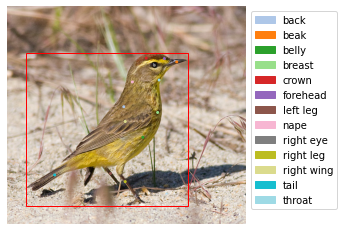

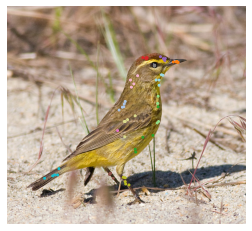

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


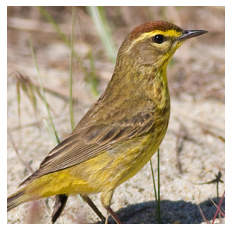

In [2]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = CUB_train_transform(Subset(cub, train_indices))
cub_test = CUB_test_transform(Subset(cub, test_indices))

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

class id: 155
l2^2(grad): 0.27649858593940735


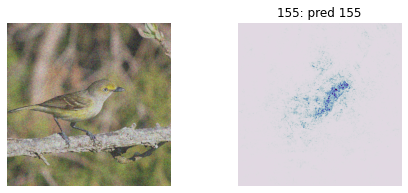

class id: 18
l2^2(grad): 0.892680287361145


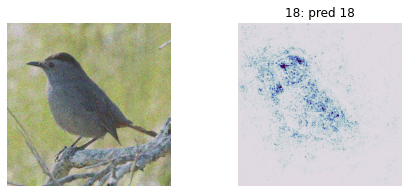

class id: 173
l2^2(grad): 0.21356594562530518


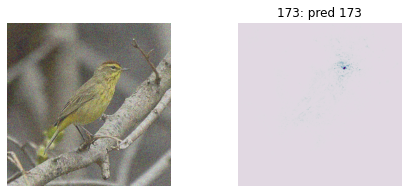

In [3]:
scale = 0.05
cub_test = TransformWrapper(CUB_test_transform(Subset(cub, test_indices)), 
                            x_transform(lambda x: x + scale * torch.randn_like(x)))

net =  nn.Sequential(torch.load(f'../outputs/e19c89eaea4911ebb773ac1f6b24a434/standard.pt'), nn.Softmax(1))
for idx in [100, 10, 45]:
    show_explanation(cub_test, idx, [net], 
                     explain_method=lambda model: IntegratedGradients(model, steps=10))

## The above shows that explanation alone is not able to identify shortcuts

The below is with input gradient regularization

class id: 155
l2^2(grad): 0.042343027889728546


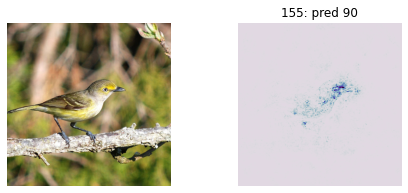

class id: 18
l2^2(grad): 0.10738835483789444


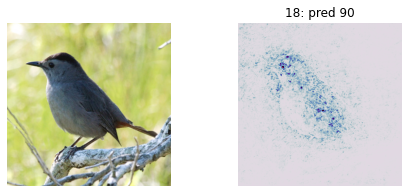

class id: 173
l2^2(grad): 8.643487672088668e-05


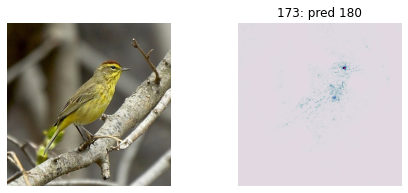

In [4]:
scale = 0.0
cub_test = TransformWrapper(CUB_test_transform(Subset(cub, test_indices)), 
                            x_transform(lambda x: x + scale * torch.randn_like(x)))

net =  nn.Sequential(torch.load(f'../outputs/9d6b1fe6330211ecb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
for idx in [100, 10, 45]:
    show_explanation(cub_test, idx, [net], 
                     explain_method=lambda model: IntegratedGradients(model, steps=10))


In [5]:
# bird need to use +1 to get the true name, say y is 155 then the correct one is 156
print(get_bird_name(155), get_bird_name(154), get_bird_name(156))
print(get_bird_name(90), get_bird_name(89), get_bird_name(91))

155.Warbling_Vireo 154.Red_eyed_Vireo 156.White_eyed_Vireo
090.Red_breasted_Merganser 089.Hooded_Merganser 091.Mockingbird


# masking the input

class id: 155
l2^2(grad): 0.000939160818234086


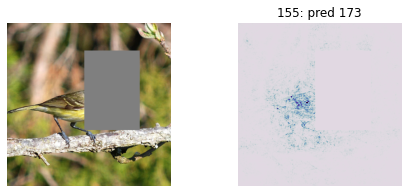

class id: 18
l2^2(grad): 0.10502680391073227


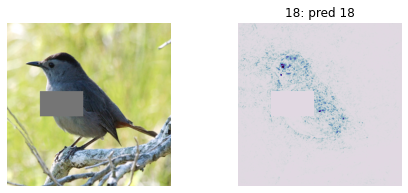

class id: 173
l2^2(grad): 8.643487672088668e-05


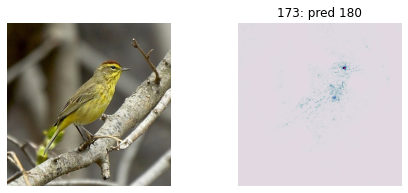

In [6]:
cub_test = TransformWrapper(CUB_test_transform(Subset(cub, test_indices)), 
                            x_transform(transforms.RandomErasing()))
net = nn.Sequential(torch.load(f'../outputs/9d6b1fe6330211ecb773ac1f6b24a434/ccm.pt'), nn.Softmax(1))
for idx in [100, 10, 45]:
    show_explanation(cub_test, idx, [net], 
                     explain_method=lambda model: IntegratedGradients(model, steps=10))

In [7]:
a = torch.arange(10).reshape(5, 2).float()
#a.requires_grad = True
#with torch.no_grad():
b = a.sum()

#b.requires_grad = True
b

tensor(45.)